**Imports**

In [ ]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score
)

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import lightgbm as lgb
from catboost import CatBoostRegressor

import warnings
warnings.filterwarnings("ignore")

import joblib


**Model best parameters**

In [ ]:
# Select model
model_choice = 'cb'  # 'rf', 'gb', 'cb', 'lgbm'


# Insert best parameters
best_params = {
    # Replace with your best parameters
    'iterations': 1000,
    'learning_rate': 0.01,
    'depth': 4,
    'l2_leaf_reg': 10,
    'bagging_temperature': 1
}


**loading data**

In [10]:
path = "C:/Users/Dell/Downloads/training/"

X_train = pd.read_csv(path + 'X_train_20260219.csv')
y_train = pd.read_csv(path + 'y_train_20260219.csv').iloc[:, 0]

X_eval = pd.read_csv(path + 'X_eval_20260219.csv')
y_eval = pd.read_csv(path + 'y_eval_20260219.csv').iloc[:, 0]

data = pd.read_csv("C:/Users/Dell/Downloads/data/merged_cleaned_20260212.csv")

cols_to_drop = [
    'Wholesale_kamis.2',
    'Wholesale_kamis.3',
    'Wholesale_kamis.1',
]

X_train = X_train.drop(columns=cols_to_drop, errors='ignore')
X_eval  = X_eval.drop(columns=cols_to_drop, errors='ignore')


In [ ]:
cat_encoders = joblib.load(path + "cat_encoder.joblib")

**Initialise model**

In [ ]:
# Initialise model
models = {
    'rf'    : RandomForestRegressor(random_state=42, n_jobs=-1),
    'gb'    : GradientBoostingRegressor(random_state=42),
    'cb'    : CatBoostRegressor(random_state=42, silent=True),
    'lgbm'  : lgb.LGBMRegressor(random_state=42, n_jobs=-1)
}

if model_choice == 'cb':
    model = CatBoostRegressor(random_state=42, silent=True, **best_params)
else:
    model = models[model_choice].set_params(**best_params)


**Cross validation**

In [ ]:
tscv = TimeSeriesSplit(n_splits=5)

cv_metrics = []

for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train), 1):

    # Split fold
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    # Fresh model per fold (VERY IMPORTANT)
    fold_model = model.__class__(**model.get_params())

    # Fit only on fold training
    fold_model.fit(X_tr, y_tr)

    # Predict on val
    y_eval_pred = fold_model.predict(X_val)

    # Metrics on calibrated preds
    mae = mean_absolute_error(y_val, y_eval_pred)
    rmse = np.sqrt(mean_squared_error(y_val, y_eval_pred))
    r2 = r2_score(y_val, y_eval_pred)

    cv_metrics.append([fold, mae, rmse, r2])

cv_results = pd.DataFrame(
    cv_metrics,
    columns=["Fold", "MAE", "RMSE", "R2"]
)

cv_results


,Fold,MAE,RMSE,R2
0,1,2.483080,3.896076,0.449306
1,2,1.598806,2.312684,0.730079
2,3,1.254971,2.369596,0.757275
3,4,1.605644,2.504480,0.611588
4,5,1.295270,2.457467,0.676535


In [16]:
cv_summary = cv_results.describe().loc[['mean','std']]
cv_summary

,Fold,MAE,RMSE,R2
mean,3.000000,1.647554,2.708061,0.644957
std,1.581139,0.495091,0.668301,0.122730


**Training and evaluation**

In [17]:
# Train model on full training data
model.fit(X_train, y_train)

In [18]:
# Training performance (In sample)
y_train_pred = model.predict(X_train)

train_mae = mean_absolute_error(y_train, y_train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_r2 = r2_score(y_train, y_train_pred)

train_bias = np.mean(y_train_pred - y_train)
train_mape = np.mean(np.abs((y_train - y_train_pred) / y_train)) * 100


In [19]:
# Final model on evaluation set (True OOS)

y_eval_pred = model.predict(X_eval)
eval_mae = mean_absolute_error(y_eval, y_eval_pred)
eval_rmse = np.sqrt(mean_squared_error(y_eval, y_eval_pred))
eval_r2 = r2_score(y_eval, y_eval_pred)

eval_bias = np.mean(y_eval_pred - y_eval)
eval_mape = np.mean(np.abs((y_eval - y_eval_pred) / y_eval)) * 100


In [20]:
# Metrics summary table
final_results = pd.DataFrame({
    "Dataset": ["Training", "Evaluation"],
    "MAE": [train_mae, eval_mae],
    "RMSE": [train_rmse, eval_rmse],
    "R2": [train_r2, eval_r2],
    "MAPE (%)": [train_mape, eval_mape],
    "Bias": [train_bias, eval_bias]
})

final_results


,Dataset,MAE,RMSE,R2,MAPE (%),Bias
0,Training,1.166521,1.922539,0.860064,3.036775,-0.000685
1,Evaluation,0.990084,1.400658,0.598337,2.936729,0.420449


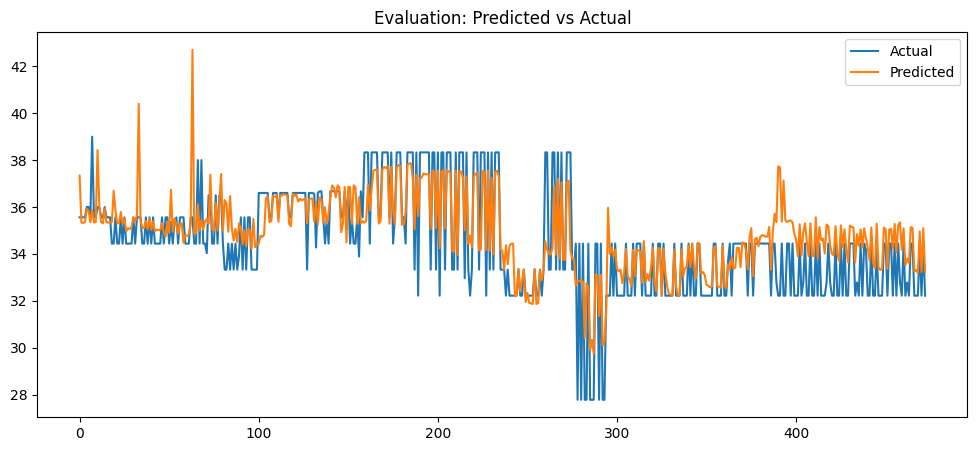

In [21]:
# Diagnotstic plots

plt.figure(figsize=(12,5))
plt.plot(y_eval.values, label="Actual")
plt.plot(y_eval_pred, label="Predicted")
plt.legend()
plt.title("Evaluation: Predicted vs Actual")
plt.show()

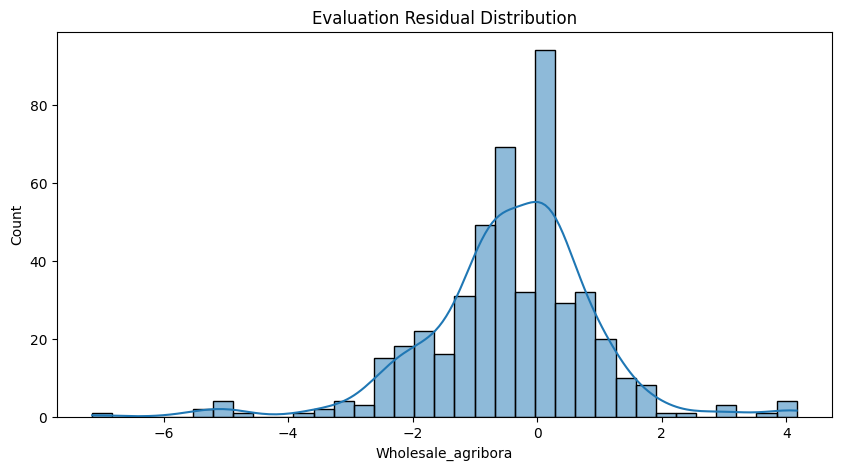

In [22]:
residuals = y_eval - y_eval_pred

plt.figure(figsize=(10,5))
sns.histplot(residuals, kde=True)
plt.title("Evaluation Residual Distribution")
plt.show()


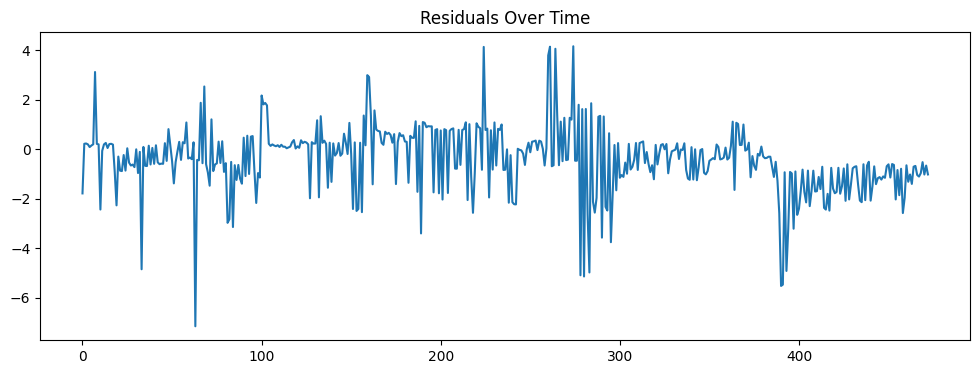

In [23]:
plt.figure(figsize=(12,4))
plt.plot(residuals)
plt.title("Residuals Over Time")
plt.show()


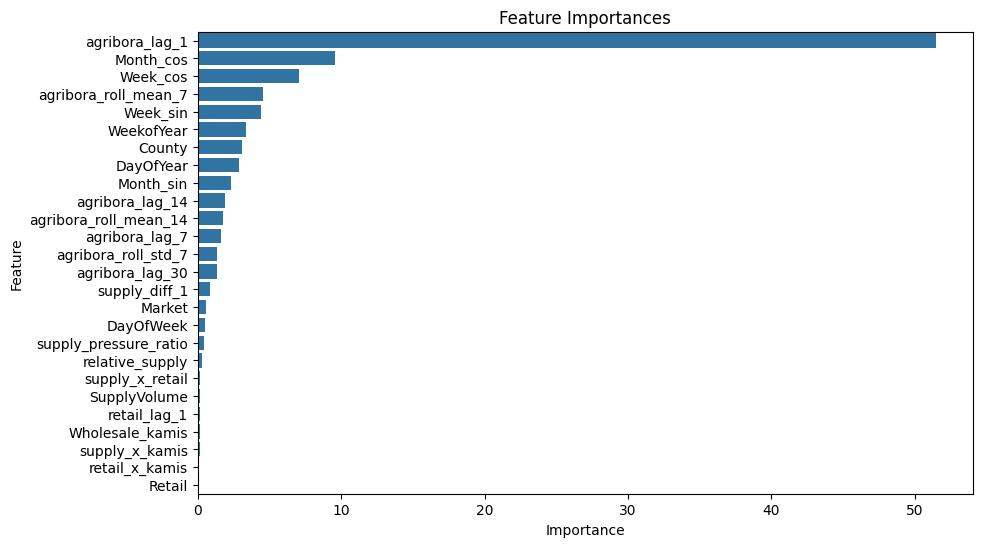

In [24]:
if hasattr(model, "feature_importances_"):
    fi = pd.DataFrame({
        "Feature": X_train.columns,
        "Importance": model.feature_importances_
    }).sort_values("Importance", ascending=False)
    
    plt.figure(figsize=(10,6))
    sns.barplot(x="Importance", y="Feature", data=fi.head(29))
    plt.title("Feature Importances")
    plt.show()
    
   


In [25]:
overfit_gap = eval_rmse - train_rmse
print("RMSE Generalization Gap:", overfit_gap)


RMSE Generalization Gap: -0.5218810371964797


In [26]:
print("===== FINAL MODEL SUMMARY =====")
print(final_results)
print("\nCV Mean RMSE:", cv_summary.loc['mean','RMSE'])
print("CV RMSE Std:", cv_summary.loc['std','RMSE'])


===== FINAL MODEL SUMMARY =====
      Dataset       MAE      RMSE        R2  MAPE (%)      Bias
0    Training  1.166521  1.922539  0.860064  3.036775 -0.000685
1  Evaluation  0.990084  1.400658  0.598337  2.936729  0.420449

CV Mean RMSE: 2.708060781249818
CV RMSE Std: 0.6683008825501477


**Week 52 and 01 forecast**

In [27]:
y_eval_pred = np.clip(y_eval_pred, 38, 55)

In [28]:
# Use the most frequent Market per County as the default future Market
county_to_market = (
    data.groupby("County")["Market"]
    .agg(lambda x: x.value_counts().index[0])
    .to_dict()
)

counties = list(county_to_market.keys())
print(county_to_market)

{'Kiambu': 'Business', 'Kirinyaga': 'Ngurubani_Market', 'Mombasa': 'Kongowea_Market', 'Nairobi': 'Nyamakima_Market', 'Uasin-Gishu': 'Eldoret_Main_Market'}


In [ ]:
target_col = "Wholesale_agribora"
cat_cols = ["County", "Market"]

# Make sure Date is datetime
data["Date"] = pd.to_datetime(data["Date"])

# Load fitted TargetEncoder (fit previously on df_model[["County","Market"]] with y=df_model[target_col])
cat_encoder = joblib.load(path + "cat_encoder.joblib")

# We forecast far ahead to cover week 52 of 2025 and week 1 of 2026
forecast_end_date = pd.to_datetime("2026-01-03")

# Stability bounds (optional but helpful for long horizon recursion)
min_price = float(data[target_col].min())
max_price = float(data[target_col].max())

# If you want ONLY the 5 required counties
counties = ["Kiambu", "Kirinyaga", "Mombasa", "Nairobi", "Uasin-Gishu"]

# Create a default Market per County (mode market within that county)
county_to_market = (
    data.groupby("County")["Market"]
    .agg(lambda x: x.value_counts().index[0])
    .to_dict()
)

# Time features
def create_time_features(date):
    return {
        "Year"          : date.year,
        "Month"         : date.month,
        "Day"           : date.day,
        "WeekofYear"    : int(date.isocalendar().week),
        "DayOfWeek"     : date.dayofweek,
        "IsWeekend"     : int(date.dayofweek >= 5),
        "DayOfYear"     : date.dayofyear,
        "Quarter"       : date.quarter,
        "IsMonthStart"  : int(date.is_month_start),
        "IsMonthEnd"    : int(date.is_month_end),
        "Month_sin"     : np.sin(2 * np.pi * date.month / 12),
        "Month_cos"     : np.cos(2 * np.pi * date.month / 12),
        "Dow_sin"       : np.sin(2 * np.pi * date.dayofweek / 7),
        "Dow_cos"       : np.cos(2 * np.pi * date.dayofweek / 7),
        "Week_sin"      : np.sin(2 * np.pi * int(date.isocalendar().week) / 52),
        "Week_cos"      : np.cos(2 * np.pi * int(date.isocalendar().week) / 52),
        "Is_holiday"    : int(int(date.isocalendar().week) in [51, 52, 1]),
    }

# Recursive daily forecast by county
future_rows = []

for county in counties:

    county_data = data[data["County"] == county].copy().sort_values("Date").reset_index(drop=True)

    if county_data.empty:
        raise ValueError(f"No historical data found for County='{county}' in data.")

    default_market = 'Business'

    last_date = county_data["Date"].max()

    future_dates = pd.date_range(
        start=last_date + pd.Timedelta(days=1),
        end=forecast_end_date,
        freq="D"
    )

    # ensure we have enough history for lags (7/14/30)
    if len(county_data) < 31:
        raise ValueError(f"Not enough history for County='{county}' to compute 30-day lag (need >=31 rows).")

    for date in future_dates:

        new_row = {"Date": date}

        # keep categoricals as STRINGS for the encoder 
        new_row["County"] = county
        new_row["Market"] = default_market

        # time features 
        new_row.update(create_time_features(date))

        # carry-forward drivers
        new_row["SupplyVolume"]     = float(county_data["SupplyVolume"].iloc[-1])
        new_row["Retail"]           = float(county_data["Retail"].iloc[-1])
        new_row["Wholesale_kamis"]  = float(county_data["Wholesale_kamis"].iloc[-1])

        # target lags
        new_row["agribora_lag_1"]  = float(county_data[target_col].iloc[-1])
        new_row["agribora_lag_7"]  = float(county_data[target_col].iloc[-7])
        new_row["agribora_lag_14"] = float(county_data[target_col].iloc[-14])
        new_row["agribora_lag_30"] = float(county_data[target_col].iloc[-30])

        # target rolling 
        new_row["agribora_roll_mean_7"]  = float(county_data[target_col].iloc[-7:].mean())
        new_row["agribora_roll_mean_14"] = float(county_data[target_col].iloc[-14:].mean())
        new_row["agribora_roll_std_7"]   = float(county_data[target_col].iloc[-7:].std())

        # supply lag/roll
        new_row["supply_lag_1"]         = float(county_data["SupplyVolume"].iloc[-1])
        new_row["supply_lag_7"]         = float(county_data["SupplyVolume"].iloc[-7])
        new_row["supply_roll_mean_7"]   = float(county_data["SupplyVolume"].iloc[-7:].mean())
        new_row["supply_roll_std_7"]    = float(county_data["SupplyVolume"].iloc[-7:].std())
        new_row["supply_diff_1"]        = 0.0  # unknown future supply change

        # retail/kamis lags (only if model expects them)
        if "retail_lag_1" in model.feature_names_:
            new_row["retail_lag_1"] = float(county_data["Retail"].iloc[-1])
        if "kamis_lag_1" in model.feature_names_:
            new_row["kamis_lag_1"] = float(county_data["Wholesale_kamis"].iloc[-1])

        # interactions
        new_row["supply_x_retail"] = float(new_row["SupplyVolume"] * new_row["Retail"])
        new_row["supply_x_kamis"]  = float(new_row["SupplyVolume"] * new_row["Wholesale_kamis"])
        new_row["retail_x_kamis"]  = float(new_row["Retail"] * new_row["Wholesale_kamis"])

        new_row["relative_supply"]          = float(new_row["SupplyVolume"] / (county_data["SupplyVolume"].mean() + 1))
        new_row["supply_pressure_ratio"]    = float(new_row["SupplyVolume"] / (new_row["supply_roll_mean_7"] + 1))

       
        # BUILD X_future + APPLY TARGET ENCODER (2 cols!)

        X_future = pd.DataFrame([new_row])

        # Encode only the categorical columns (must be 2 columns)
        X_cat = X_future[cat_cols].copy()
        X_cat_enc = cat_encoder.transform(X_cat)

        # Replace with encoded values
        X_future[cat_cols] = X_cat_enc[cat_cols]

        # Align features to model
        # Add any missing features expected by the model
        missing_cols = [c for c in model.feature_names_ if c not in X_future.columns]
        for c in missing_cols:
            X_future[c] = 0

        # Keep correct order and enforce numeric dtype
        X_future = X_future[model.feature_names_].astype(float)

        # Predict

        y_pred = model.predict(X_future)
        y_pred_val = float(y_pred[0])

        # Optional stability clip
        y_pred_val = float(np.clip(y_pred_val, min_price, max_price))

        # Store prediction as target for recursion
        new_row[target_col] = y_pred_val

        # Append to county history for next step (keep strings for County/Market)
        county_append = pd.DataFrame([new_row])
        county_data = pd.concat([county_data, county_append], ignore_index=True)

        # Save a readable county for later ID
        new_row["County_name"] = county
        future_rows.append(new_row)

# All future daily predictions
future_df = pd.DataFrame(future_rows)

#Get weekly mean

weekly_forecast = (
    future_df
    .groupby(["Year", "WeekofYear", "County_name"])[target_col]
    .mean()
    .reset_index()
    .rename(columns={"County_name": "County"})
)

# Filter for required weeks
submission_weeks = weekly_forecast[
    ((weekly_forecast["Year"] == 2025) & (weekly_forecast["WeekofYear"] == 52)) |
    ((weekly_forecast["Year"] == 2026) & (weekly_forecast["WeekofYear"] == 1))
].copy()

# 10 rows (5 counties x 2 weeks)
print("Rows in submission_weeks:", len(submission_weeks))
print(submission_weeks.sort_values(["Year","WeekofYear","County"]))

# Submission file
submission_weeks["ID"] = submission_weeks["County"] + "_Week_" + submission_weeks["WeekofYear"].astype(str)

submission = submission_weeks[["ID"]].copy()
submission["Target_RMSE"] = submission_weeks[target_col]
submission["Target_MAE"]  = submission_weeks[target_col]

# Force correct week order: Week 52 first, then Week 1
submission["WeekOrder"] = submission["ID"].apply(
    lambda x: 0 if "_Week_52" in x else 1
)

submission = (
    submission
    .sort_values(["WeekOrder", "ID"])
    .drop(columns="WeekOrder")
    .reset_index(drop=True)
)

submission.to_csv("submission_f.csv", index=False)

print(submission)


Rows in submission_weeks: 10
    Year  WeekofYear       County  Wholesale_agribora
77  2025          52       Kiambu           41.520380
78  2025          52    Kirinyaga           41.514688
79  2025          52      Mombasa           41.488588
80  2025          52      Nairobi           41.567828
81  2025          52  Uasin-Gishu           41.496953
82  2026           1       Kiambu           40.782019
83  2026           1    Kirinyaga           40.769296
84  2026           1      Mombasa           40.745295
85  2026           1      Nairobi           40.850949
86  2026           1  Uasin-Gishu           40.741854
                    ID  Target_RMSE  Target_MAE
0       Kiambu_Week_52    41.520380   41.520380
1    Kirinyaga_Week_52    41.514688   41.514688
2      Mombasa_Week_52    41.488588   41.488588
3      Nairobi_Week_52    41.567828   41.567828
4  Uasin-Gishu_Week_52    41.496953   41.496953
5        Kiambu_Week_1    40.782019   40.782019
6     Kirinyaga_Week_1    40.769296   40.

In [30]:
submission

,ID,Target_RMSE,Target_MAE
0,Kiambu_Week_52,41.520380,41.520380
1,Kirinyaga_Week_52,41.514688,41.514688
2,Mombasa_Week_52,41.488588,41.488588
3,Nairobi_Week_52,41.567828,41.567828
4,Uasin-Gishu_Week_52,41.496953,41.496953
5,Kiambu_Week_1,40.782019,40.782019
6,Kirinyaga_Week_1,40.769296,40.769296
7,Mombasa_Week_1,40.745295,40.745295
8,Nairobi_Week_1,40.850949,40.850949
9,Uasin-Gishu_Week_1,40.741854,40.741854
